In [90]:
%matplotlib inline
import math
from QuantLib import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from datetime import datetime

plt.style.use('fivethirtyeight')

In [16]:
today = Date(11, December, 2012)
Settings.instance().evaluationDate = today

In [23]:
helpers = [DepositRateHelper(QuoteHandle(SimpleQuote(rate/100)), 
                               Period(1, Days), fixingDays,
                               UnitedStates(), Following, False, Actual360())
          for rate, fixingDays in [(0.04, 0), (0.04, 1), (0.04, 2)]]

In [24]:
fedFunds = FedFunds()
helpers += [OISRateHelper(2, Period(*tenor),
                         QuoteHandle(SimpleQuote(rate/100)), fedFunds)
           for rate, tenor in [(0.070, (1, Weeks)), (0.069, (2, Weeks)),
                              (0.078, (3, Weeks)), (0.074, (1, Months))]]

In [25]:
helpers += [DatedOISRateHelper(start_date, end_date,
                                 QuoteHandle(SimpleQuote(rate/100)), fedFunds)
           for rate, start_date, end_date in [
               (0.046, Date(16,January,2013), Date(13,February,2013)),
               (0.016, Date(13,February,2013), Date(13,March,2013)),
               (-0.007, Date(13,March,2013), Date(10,April,2013)),
               (-0.013, Date(10,April,2013), Date(8,May,2013)),
               (-0.014, Date(8,May,2013), Date(12,June,2013))]]

In [26]:
helpers += [OISRateHelper(2, Period(*tenor),
                         QuoteHandle(SimpleQuote(rate/100)), fedFunds)
           for rate, tenor in [(0.002, (15,Months)), (0.008, (18,Months)),
                               (0.021, (21,Months)), (0.036, (2,Years)),
                               (0.127, (3,Years)), (0.274, (4,Years)),
                               (0.456, (5,Years)), (0.647, (6,Years)),
                               (0.827, (7,Years)), (0.996, (8,Years)),
                               (1.147, (9,Years)), (1.280, (10,Years)),
                               (1.404, (11,Years)), (1.516, (12,Years)),
                               (1.764, (15,Years)), (1.939, (20,Years)),
                               (2.003, (25,Years)), (2.038, (30,Years))]]

In [27]:
fedFunds_curve_c = PiecewiseLogCubicDiscount(0, UnitedStates(),
                                            helpers, Actual365Fixed())
fedFunds_curve_c.enableExtrapolation()

In [87]:
today = fedFunds_curve_c.referenceDate()
end = today + Period(2, Years)
dates = [Date(serial) for serial in range(today.serialNumber(),
                                         end.serialNumber()+1)]
rates_c = [fedFunds_curve_c.forwardRate(d, UnitedStates().advance(d, 1, Days),
                                       Actual360(), Simple).rate()
          for d in dates]

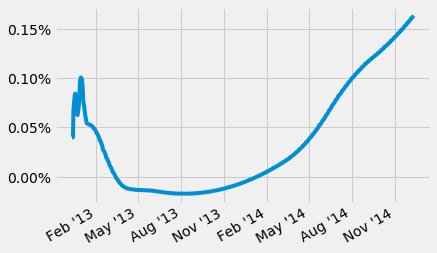

In [93]:
x = [datetime(date.year(), date.month(), date.dayOfMonth()) for date in dates]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b \'%y'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
plt.plot(x, rates_c, '-')
plt.gcf().autofmt_xdate()

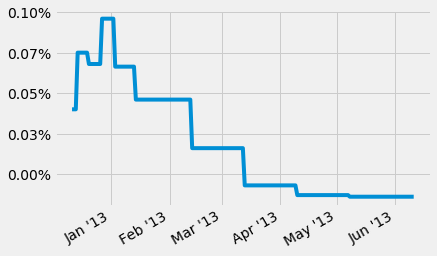

In [105]:
fedFunds_curve_ff = PiecewiseFlatForward(0, UnitedStates(), 
                                         helpers, Actual365Fixed())
fedFunds_curve_ff.enableExtrapolation()

end = today + Period(6, Months)
dates = [Date(serial) for serial in range(today.serialNumber(),
                                         end.serialNumber()+1)]
rates_ff = [fedFunds_curve_ff.forwardRate(d, UnitedStates().advance(d, 1, Days),
                                         Actual360(), Simple).rate()
            for d in dates]

x = [datetime(date.year(), date.month(), date.dayOfMonth()) for date in dates]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b \'%y'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
plt.plot(x, rates_ff, '-')
plt.gcf().autofmt_xdate()

In [101]:
nodes = list(fedFunds_curve_ff.nodes())
nodes[:9]

[(Date(11,12,2012), 0.00040555533025081675),
 (Date(12,12,2012), 0.00040555533025081675),
 (Date(13,12,2012), 0.00040555533047721286),
 (Date(14,12,2012), 0.00040555533047721286),
 (Date(20,12,2012), 0.0007604110692568178),
 (Date(27,12,2012), 0.0006894305026004767),
 (Date(3,1,2013), 0.0009732981324671213),
 (Date(14,1,2013), 0.0006728161005748453),
 (Date(13,2,2013), 0.000466380545910482)]

In [103]:
nodes[6] = (nodes[6][0], (nodes[5][1] + nodes[7][1])/2)

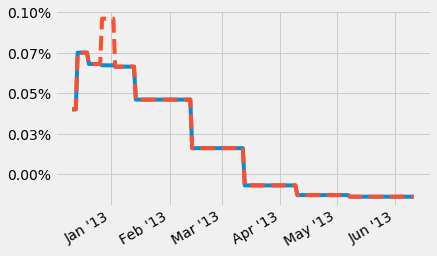

In [106]:
temp_dates, temp_rates = zip(*nodes)
temp_curve = ForwardCurve(temp_dates, temp_rates,
                         fedFunds_curve_ff.dayCounter())
temp_rates = [temp_curve.forwardRate(d, UnitedStates().advance(d, 1, Days),
                                    Actual360(), Simple).rate()
             for d in dates]

x = [datetime(date.year(), date.month(), date.dayOfMonth()) for date in dates]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b \'%y'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
plt.plot(x, temp_rates, '-')
plt.plot(x, rates_ff, '--')
plt.gcf().autofmt_xdate()

In [113]:
d1 = Date(31, December, 2012) - Period(1, Weeks)
d2 = Date(31, December, 2012) + Period(1, Weeks)

F = fedFunds_curve_ff.forwardRate(d1, d2, Actual360(), Simple).rate()
F_1 = temp_curve.forwardRate(d1, d2, Actual360(), Simple).rate()
print('{0:.3%}'.format(F))
print('{0:.3%}'.format(F_1))

0.082%
0.067%


In [114]:
t12 = fedFunds_curve_ff.dayCounter().yearFraction(d1, d2)
t_j = fedFunds_curve_ff.dayCounter().yearFraction(Date(31, December, 2012),
                                                 Date(2, January, 2013))
J = (F - F_1)*t12/t_j
print('{0:.3%}'.format(J))

0.101%


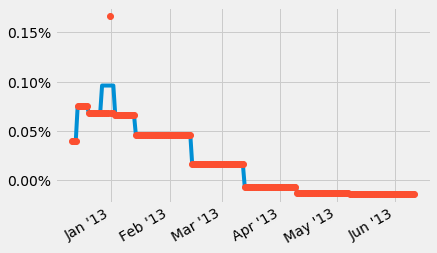

In [118]:
B = 1/(1+J*t_j)
jumps = [QuoteHandle(SimpleQuote(B))]
jump_dates = [Date(31, December, 2012)]
fedFunds_curve_j = PiecewiseFlatForward(0, UnitedStates(), 
                                       helpers, Actual365Fixed(),
                                       jumps, jump_dates)
rates_j = [ fedFunds_curve_j.forwardRate(d, UnitedStates().advance(d, 1, Days),
                                        Actual360(), Simple).rate()
          for d in dates]

x = [datetime(date.year(), date.month(), date.dayOfMonth()) for date in dates]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b \'%y'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
plt.plot(x, rates_ff, '-')
plt.plot(x, rates_j, 'o')
plt.gcf().autofmt_xdate()

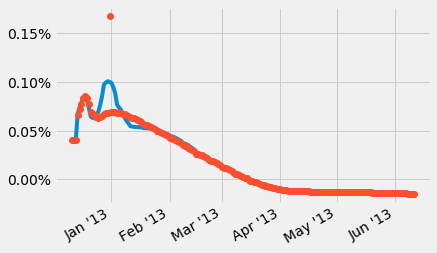

In [119]:
fedFunds_curve = PiecewiseLogCubicDiscount(0, UnitedStates(),
                                          helpers, Actual365Fixed(),
                                          jumps, jump_dates)
fedFunds_curve.enableExtrapolation()
rates_c = [fedFunds_curve_c.forwardRate(d, UnitedStates().advance(d, 1, Days),
                                       Actual360(), Simple).rate()
          for d in dates]
rates = [fedFunds_curve.forwardRate(d, UnitedStates().advance(d, 1, Days),
                                   Actual360(), Simple).rate()
        for d in dates]

x = [datetime(date.year(), date.month(), date.dayOfMonth()) for date in dates]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b \'%y'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
plt.plot(x, rates_c, '-')
plt.plot(x, rates, 'o')
plt.gcf().autofmt_xdate()

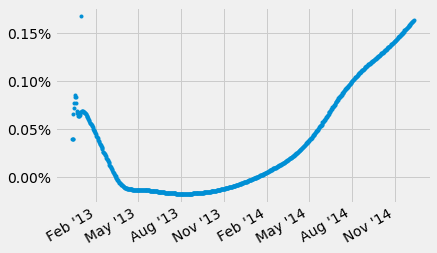

In [122]:
dates = [today + Period(i, Days) for i in range(0, 365*2+1)]
rates = [fedFunds_curve.forwardRate(d, UnitedStates().advance(d, 1, Days),
                                   Actual360(), Simple).rate()
        for d in dates]

x = [datetime(date.year(), date.month(), date.dayOfMonth()) for date in dates]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b \'%y'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
plt.plot(x, rates, '.')
plt.gcf().autofmt_xdate()

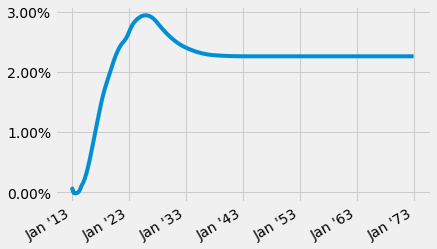

In [123]:
dates = [today+Period(i, Months) for i in range(0, 12*60+1)]
rates = [fedFunds_curve.forwardRate(d, UnitedStates().advance(d, 1, Days),
                                   Actual360(), Simple).rate()
        for d in dates]
x = [datetime(date.year(), date.month(), date.dayOfMonth()) for date in dates]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b \'%y'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
plt.plot(x, rates, '-')
plt.gcf().autofmt_xdate()